# Content:


edd

### Import relevant libraries

In [1]:
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

DEPRECATION: tsfresh 0.18.0 has a non-standard dependency specifier matrixprofile>=1.1.10<2.0.0. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tsfresh or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Read the Data

In [2]:
from google.colab import files
import io
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
first_key = next(iter(uploaded))
uploaded.keys()

dict_keys(['spam.csv'])

In [ ]:
uploaded = uploaded[first_key]
df = pd.read_csv(io.BytesIO(uploaded))

In [ ]:
#df= pd.read_csv('spam.csv')
#df.describe(include='all')

In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

### Preprocessing

##### Duplicates

In [ ]:
df = df.drop_duplicates()

##### Balance the data

In [ ]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']

df_ham_downsampled = df_ham.sample(df_spam.shape[0], random_state=42)

df_balanced = pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape


(1282, 2)

##### Binary representation of spam

In [ ]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0)

##### Split the data with shuffling

In [ ]:
from sklearn.model_selection import train_test_split
inputs = df_balanced['Message']
targets = df_balanced['spam']
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, stratify = df_balanced['spam'])

In [ ]:
import numpy as np
np.bincount(train_targets)
# 0 appeared 480 times
# 1 appeared 481 times

array([481, 480])

### BERT

##### preprocessor and encoder

In [ ]:
preprocessing_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocessor = hub.KerasLayer(preprocessing_url)

##### Small Demonstration

In [ ]:
sample_text = ["nice movie indeed", "I love Python Programming","mango", "apple"]
preprocessed_text = bert_preprocessor(sample_text)
preprocessed_text.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])

###### The keys:
1. 'input_word_ids': Contains tokenized and integer-encoded text, representing words and subwords converted to numerical IDs.
2. 'input_mask': A binary mask indicating which tokens are actual input (1) and which are padding (0), ensuring consistent input sequence lengths.
3. 'input_type_ids' (optional): Represents segment IDs for multiple sentence inputs, used in tasks with multiple segments; may be absent for single-sentence input.

In [ ]:
preprocessed_text['input_mask'][0]
# although our first sentence is of 3 words, we got 5  1's,
# it has put special token CLS in the beginning and
# to seperate 2 sentences, SEP, separator in the end

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
preprocessed_text['input_word_ids'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([ 101, 3835, 3185, 5262,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
# Now we add another layer for bert model
bert_model = hub.KerasLayer(encoder_url)

bert_results = bert_model(preprocessed_text)
bert_results.keys()

dict_keys(['encoder_outputs', 'pooled_output', 'default', 'sequence_output'])

##### The keys:
1. 'sequence_output': Contextualized token representations in the input text.
2. 'pooled_output': A fixed-size embedding for the entire input sequence.
3. 'encoder_outputs' (optional): Hidden states of the BERT model, containing internal representations.
  - Two types of bert: base amd large, here we used the base one so the length of it will be 12
4. 'default': It can be used to access BERT model outputs when no specific key is specified.

In [ ]:
bert_results['pooled_output']
# here we got embedding vector for all the 128 inputs shown above

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.7917741 , -0.21411912,  0.49769545, ...,  0.24465233,
        -0.47334483,  0.81758696],
       [-0.91712326, -0.47935176, -0.7865698 , ..., -0.6175174 ,
        -0.71026856,  0.92184305],
       [-0.7128862 , -0.15463912,  0.38401636, ...,  0.3527872 ,
        -0.5099134 ,  0.73474103],
       [-0.8196458 , -0.29609624,  0.2095171 , ...,  0.2559334 ,
        -0.58743   ,  0.8434557 ]], dtype=float32)>

In [ ]:
bert_results['sequence_output'][0]
# the second array shown just below is the vector for the word 'movie' of 768 elements
# This is a contextualized embedding so the vector of padding we also have some value

<tf.Tensor: shape=(128, 768), dtype=float32, numpy=
array([[ 0.07292047,  0.08567817,  0.14476831, ..., -0.09677088,
         0.08722127,  0.07711085],
       [ 0.1783942 , -0.19006078,  0.5034952 , ..., -0.05869824,
         0.32717073, -0.15578493],
       [ 0.18701449, -0.43388748, -0.4887515 , ..., -0.15502778,
         0.00145182, -0.24471016],
       ...,
       [ 0.12083091,  0.12884252,  0.46453542, ...,  0.0737552 ,
         0.17441946,  0.16522075],
       [ 0.07967882, -0.01190652,  0.502254  , ...,  0.13777725,
         0.21002197,  0.00624588],
       [-0.07212701, -0.28303462,  0.59033376, ...,  0.475519  ,
         0.16668482, -0.08920349]], dtype=float32)>

###### Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
results = bert_results['pooled_output']
cosine_similarity([results[2]],[results[3]])
# this shows that mango and apple are similar


array([[0.96140397]], dtype=float32)

##### Demonstration complete: continuation of model

#### We create function to get embedding vector

In [ ]:
def get_sentence_embedding(sentence):
  preprocessed_sentence = bert_preprocessor(sentence)
  result = bert_model(preprocessed_sentence)
  return result['pooled_output']

#### We create functional model

In [ ]:
 # BERT layers
text_inputs = tf.keras.layers.Input(shape=(), dtype = tf.string, name='bert_input')
preprocessed_text = bert_preprocessor(text_inputs)
outputs = bert_model(preprocessed_text)

# Neural Network Layer
dropout_layer = tf.keras.layers.Dropout(0.2,name='drop_layer')(outputs['pooled_output'])
result = tf.keras.layers.Dense(1,activation = 'sigmoid', name = 'final_output')(dropout_layer)

# construct final model
model = tf.keras.Model(inputs=[text_inputs], outputs= [result])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['bert_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

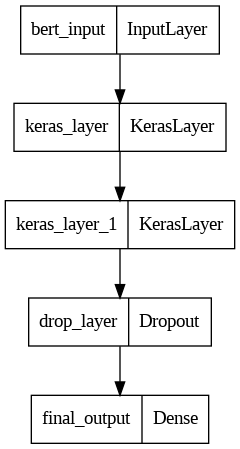

In [ ]:
from tensorflow.keras.utils import *


plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

#### Compile and evaluate the model

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'Accuracy'),
    tf.keras.metrics.Precision(name = 'Precision'),
    tf.keras.metrics.Recall(name = 'Recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = METRICS)

In [ ]:
model.fit(train_inputs,train_targets,epochs =10)

Epoch 1/10
31/31 [==============================] - 563s 18s/step - loss: 0.6529 - Accuracy: 0.6223 - Precision: 0.6232 - Recall: 0.6167
Epoch 2/10
31/31 [==============================] - 430s 14s/step - loss: 0.5464 - Accuracy: 0.7440 - Precision: 0.7276 - Recall: 0.7792
Epoch 3/10
31/31 [==============================] - 421s 14s/step - loss: 0.4704 - Accuracy: 0.8241 - Precision: 0.8233 - Recall: 0.8250
Epoch 4/10
31/31 [==============================] - 420s 14s/step - loss: 0.4310 - Accuracy: 0.8470 - Precision: 0.8364 - Recall: 0.8625
Epoch 5/10
31/31 [==============================] - 420s 14s/step - loss: 0.4017 - Accuracy: 0.8626 - Precision: 0.8412 - Recall: 0.8938
Epoch 6/10
31/31 [==============================] - 421s 14s/step - loss: 0.3700 - Accuracy: 0.8741 - Precision: 0.8554 - Recall: 0.9000
Epoch 7/10
31/31 [==============================] - 423s 14s/step - loss: 0.3493 - Accuracy: 0.8855 - Precision: 0.8642 - Recall: 0.9146
Epoch 8/10
31/31 [=======================

In [ ]:
model.evaluate(test_inputs, test_targets)

11/11 [==============================] - 143s 13s/step - loss: 0.3275 - Accuracy: 0.8972 - Precision: 0.9444 - Recall: 0.8447


[0.3274734914302826,
 0.8971962332725525,
 0.9444444179534912,
 0.8447204828262329]

### Visualize the findings

#### y_predicted

In [ ]:
y_predicted = model.predict(test_inputs)
y_predicted = y_predicted.flatten() # to convert into 1 dimentional array

11/11 [==============================] - 143s 13s/step


array([0.11203412, 0.47571686, 0.9713501 , 0.08917432, 0.49208906,
       0.83325094, 0.04865545, 0.9484084 , 0.9450161 , 0.8199021 ,
       0.41015324, 0.09439763, 0.89848626, 0.15879083, 0.014549  ,
       0.7898002 , 0.0103737 , 0.6303189 , 0.35194564, 0.84522307,
       0.93871003, 0.05338246, 0.896051  , 0.36793205, 0.16254441,
       0.87154794, 0.6784087 , 0.97371   , 0.08431292, 0.78862053,
       0.25040346, 0.94920635, 0.09284536, 0.16785984, 0.8161268 ,
       0.61999804, 0.12562504, 0.02349035, 0.34539557, 0.05662541,
       0.15584238, 0.7293263 , 0.73100626, 0.55315644, 0.9507709 ,
       0.3757481 , 0.4008992 , 0.95714605, 0.10254527, 0.94995177,
       0.05654046, 0.74775445, 0.54070973, 0.02739208, 0.9171677 ,
       0.9254585 , 0.4183997 , 0.9339762 , 0.57628846, 0.06725704,
       0.4881043 , 0.73742634, 0.12111836, 0.91984886, 0.09041379,
       0.14932121, 0.16684516, 0.17329079, 0.65863854, 0.696718  ,
       0.07324483, 0.754145  , 0.12256165, 0.21151313, 0.46307

In [ ]:
# These values are between 0 and 1, so we convert them into 0 and 1
y_predicted = np.where(y_predicted > 0.5, 1,0)
y_predicted

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,

#### Confusion matrics and classification report

Text(50.722222222222214, 0.5, 'Actual')

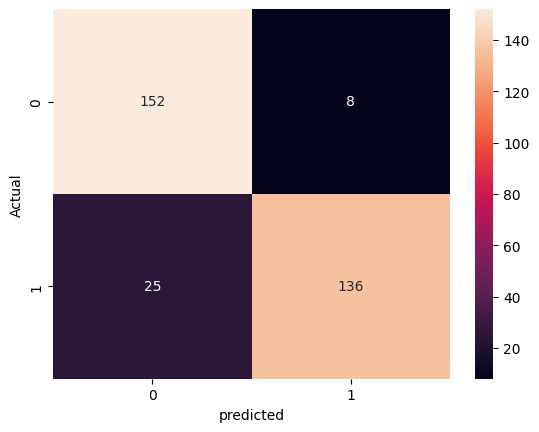

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_mat = confusion_matrix(test_targets, y_predicted)

# to make it vusually appealing

import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_mat, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Actual')

In [ ]:
print(classification_report(test_targets,y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       160
           1       0.94      0.84      0.89       161

    accuracy                           0.90       321
   macro avg       0.90      0.90      0.90       321
weighted avg       0.90      0.90      0.90       321



### Save model


In [ ]:
model_version = 1
model.save(f"D:\GITHUB\ML\4_NLP\BERT\1_Spam_Email_Detector/{model_version}")